# 📘 Example: Advanced Scenario

In this notebook we demonstrate the **workflow** on how you can build an advanced **FloodAdapt scenario** in Charleston, USA, using the **API**.  

In this notebook we will cover the following steps:

1. Create a synthetic **event** 
2. Create a **projection** - Sea level rise (SLR)
3. Create a **measure** and **strategy** - Seawall
4. Create and run a **scenario**
6. Investigate the **output**


## Import libraries

In [1]:
# Import packages
#import contextily as cx
from datetime import datetime
import geopandas as gpd
from pathlib import Path
import rasterio
import rasterio.plot
import flood_adapt.objects.forcing as f

from flood_adapt.config.sfincs import RiverModel
from flood_adapt.dbs_classes.database import Database
from flood_adapt.objects.events.synthetic import SyntheticEvent 
from flood_adapt.objects import HurricaneEvent, TimeFrame
from flood_adapt.objects.events.hurricane import TranslationModel
from flood_adapt.flood_adapt import FloodAdapt
from flood_adapt.objects.forcing.forcing import (
    ForcingSource,
    ForcingType,)
from flood_adapt.objects.measures.measures import *
from flood_adapt.objects.projections.projections import Projection, PhysicalProjection, SocioEconomicChange
from flood_adapt.objects.scenarios.scenarios import Scenario
from flood_adapt import Settings
from flood_adapt.objects.strategies.strategies import Strategy
from flood_adapt import unit_system as us

## 🚀 **Step 1**. Reading-in the FloodAdapt database

Let's start with initiating the database and FloodAdapt class. 
1. Initiate the database class [`Settings`](../../api_ref/Settings.qmd) by defining the `DATABASE_ROOT` and `DATABASE_NAME`.
2. Initiate the [`FloodAdapt`](../../api_ref/FloodAdapt.qmd) class by parsing the `Settings().database_path`.

In [2]:
# Define the static data folder
STATIC_DATA_DIR = Path("../../_data/examples/static-data/5_Advanced_Scenario").resolve()

# Set up the settings for the database
Settings(
    DATABASE_ROOT=Path("../../_data/examples").resolve(),
    DATABASE_NAME="charleston_test"
)

# Create the FloodAdapt instance
fa = FloodAdapt(Settings().database_path)

## 🌊 **Step 2**. Events - Create a synthetic Event

Events in FloodAdapt are categorized into different forcings:
1. **Wind**
2. **Rainfall**
3. **Discharge**
4. **Water Level**

If you want to learn more about the individual forcings in FloodAdapt, please go and read the section on [**Events**](../../4_user_guide/events/index.qmd) in the FloodAdapt documentation.

When creating an event, we need to create an [`Event`](../../api_ref/Event.qmd) object. Depending on which type of event we create, we select a different class. In this example we create a **synthetic event**, therefore we use the [`SyntheticEvent`](../../api_ref/objects/SyntheticEvent.qmd) class. 

To create the `SyntheticEvent` object we use the `time` attribute to define the event duration. This should be parsed as a [`TimeFrame`](../../api_ref/TimeFrame.qmd) object. In the [`forcings`](../../api_ref/IForcing.qmd) attribute we aggregated the different forcing objects in a dictionary.  

In this event example we will create an event with the following `forcings`:  
🌬️ `WindConstant`: Define a value for a constant wind speed (mps) and direction (degrees)  
🌧️ `RainfallConstant`: Define a value for a constant rainfall (mm/hr)  
💦 `DischargeConstant`: Define the x and y coordinates of the discharge point of the Cooper River and a value for a constant mean discharge (cfs) in the River- and Discharge model (same value)  
🌊 `WaterlevelSynthetic SurgeModel`: Define a peak time (h), peak value in (m) and duration (d)  
↔️ `WaterlevelSynthetic TideModel`: Define the harmonic amplitude (m), harmonic period (h) and harmonic phase (h)  

For a complete guide on all the possible event options and inputs check out the [**notebook**](../events/index.qmd) specifically on **events**.  

### **Step 2.1**: Create a Historical Hurricane Event
In FloodAdapt we can re-create and edit historical hurricanes and explore their impacts with altered parameters to answer community questions e.g. what would have happened if the hurrican made landfall further south/north?
To create a hurricane we need to do he followin steps:
1. **Set a time frame**
2. **Define the waterlevel**
3. **Obtain the hurricane track**
4. **Add rainfall** 
5. **Add wind**
6. **Add River discharge**

For a detailed description on how to create a hurricane event go to the [event notebook](../events/index.qmd).

<Axes: title={'center': 'Constant Discharge River'}, xlabel='Time', ylabel='Discharge (cms)'>

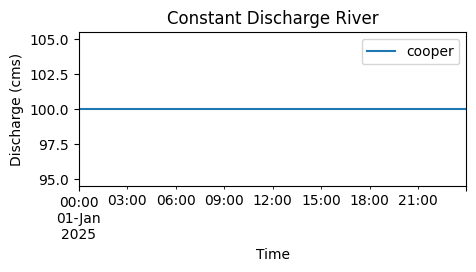

In [3]:
# Create an time frame for the simulation
start_time = datetime(year=2025, month=1, day=1) 
end_time = datetime(year=2025, month=1, day=2)
time_frame = TimeFrame(start_time=start_time, end_time=end_time)

# Define Water Level Forcing
water_levels = f.waterlevels.WaterlevelModel()

# Obtain a hurricane track
## Get the cyclone database
cyclone_db = fa.database.static.get_cyclone_track_database()
ian_index = cyclone_db.list_names().index("IAN")

## Not all cyclone tracks have names, in addition to duplicate names existing, so it is better to use the index
track = fa.get_cyclone_track_by_index(index=ian_index) 
track_file = STATIC_DATA_DIR / "IAN.cyc"
track.write_track(filename=track_file, fmt="ddb_cyc")

## Optionally translate the cyclone track from what is defined in the file
translation = TranslationModel(
    eastwest_translation=us.UnitfulLength(value=3000, units=us.UnitTypesLength.meters),
    northsouth_translation=us.UnitfulLength(value=5000, units=us.UnitTypesLength.meters),
)

# We want to include the rainfall and wind from the hurricane track
rainfall = f.rainfall.RainfallTrack(path=track_file)
wind = f.wind.WindTrack(path=track_file)

# The available rivers are defined in the hazard model when creating the database.
# You cannot add new rivers to the model in an event, you can only set the discharge of each given river.
river = fa.database.site.sfincs.river[0]

discharge = f.discharge.DischargeConstant(
    river=river,
    discharge=us.UnitfulDischarge(value=100, units=us.UnitTypesDischarge.cms)
)

# Inspect
df = discharge.to_dataframe(time_frame=time_frame)
df.plot(title="Constant Discharge River", xlabel="Time", ylabel="Discharge (cms)", legend=True, figsize=(5, 2))

🌪️🌀  Let's put the forcings together and create the [`HurricaneEvent`](../../api_ref/HurricaneEvent.qmd) object.

In [4]:
# Create a hurricaneEvent with the forcings and time frame
attrs_event = HurricaneEvent(
    name="example_hurricane_event",
    time=time_frame,
    forcings = {
        # The keys of the dictionary are the forcing types, and the values are lists of the corresponding forcing objects.
        f.forcing.ForcingType.WATERLEVEL: [water_levels],
        f.forcing.ForcingType.RAINFALL: [rainfall],
        f.forcing.ForcingType.WIND: [wind],
        f.forcing.ForcingType.DISCHARGE: [discharge],
    },
    track_name=track.name,
    hurricane_translation=translation,
)

### 💾 **Step 2.1**. Saving the event to the database

In [5]:
# Save the event to the database
fa.save_event(attrs_event)

## 📈 **Step 3**. Projections - Create a projection

**Projections** in FloodAdapt allow us to adjust our model to future conditions such as sea level rise or/and population growth. If you want to learn more about projections in FlooAdapt, please go to the section [Projections](../../4_user_guide/projections/index.qmd) in the FloodAdapt documentation. 
  
The projections can be divided into two categories:
1. 🌊 **Physical Projections**: Sea level rise, intensified precipitation, increased storm frequency
2. 💰 **Socio economic change**: Population growth (existing built area, new development area), economic growth

When creating a projection we need to create a [`Projection`](../../api_ref/Projection.qmd) object. The `PhysicalProjection` attribute is parsed as a [`PhysicalProjection`](../../api_ref/PhysicalProjection.qmd) object which captures the pysical projection such as sea lvel rise. The `SocioEconomicChange` attribute is parsed as a [`SocioEconomicChange`](../../api_ref/SocioEconomicChange.qmd) object which captures the socioeconomic projection such as population growth. It's not mandatory to parse both projections. If we only want to use one of the two types of projections we can leave the other one blank (). 

The attributes of the `PhysicalProjection` or `SocioEconomicChange` object define the projection. In this case we parse the attribute `sea_level_rise` to the `PhysicalProjection` object and define the value in [`UnitfulLength`](../../api_ref/UnitfulLength.qmd) and the unit in [`UnitTypesLength`](../../api_ref/UnitTypesLength.qmd).

To get a deeper understanding for all the possible projections and their inputs go to the [**notebook**](../projections/index.qmd) specifically about **projections**.


In this example we will make use of **sea level rise scenarios** for a `PhysicalProjection` and explore **population growth** as `SocioEconomicChange`. 

First, let's get the sea level rise scenarios from the database.  
A FloodAdapt database can include sea level rise scenarios, describing a timeline of future sea level rise relative to a reference year. If these scenarios are available in the database the get_slr_scn_names() method will return a list of the available scenarios. To get a deeper understanding on how you can create different Projections read the [**projectionblablab**](nolink) notebook.

In [6]:
# Get the Scenarios
fa.get_slr_scn_names()

# Interpolate until 2050
fa.interp_slr(slr_scenario="ssp585", year=2050)

0.6

Use that projection to create the [`Projection`](../../api_ref/Projection.qmd) object.

In [7]:
attrs_proj_2050 = Projection(name="proj_2050",
                    description="2050 projection", 
                    physical_projection= PhysicalProjection(sea_level_rise=us.UnitfulLength(value=fa.interp_slr(slr_scenario="ssp585", year=2050), units=us.UnitTypesLength.meters)), 
                    socio_economic_change=SocioEconomicChange()
                    )
attrs_proj_2050

Projection(name='proj_2050', description='2050 projection', physical_projection=PhysicalProjection(sea_level_rise=UnitfulLength(value=0.6, units=UnitTypesLength.meters), subsidence=UnitfulLength(value=0.0, units=UnitTypesLength.meters), rainfall_multiplier=1.0, storm_frequency_increase=0.0), socio_economic_change=SocioEconomicChange(population_growth_existing=0.0, economic_growth=0.0, population_growth_new=0.0, new_development_elevation=None, new_development_shapefile=None))

Now we can create the population growth projection. To capture population growth, we will create a new development area and pass the `population_growth_existing` and `population_growth_new`. You find a detalied explanation of these input attributes in the [FloodAdapt User Guide](../4_user_guide/projections/socioEconomic.qmd). 

We can have a quick look at the new development area.

In [8]:
new_dev = gpd.read_file(STATIC_DATA_DIR /"new_dev.gpkg")
new_dev.explore()

ImportError: The 'folium', 'matplotlib' and 'mapclassify' packages are required for 'explore()'. You can install them using 'conda install -c conda-forge folium matplotlib mapclassify' or 'pip install folium matplotlib mapclassify'.

Now we can create the [`SocioEconomicChange`](../../api_ref/SocioEconomicChange.qmd) object as part of the [`Projection`](../../api_ref/Projection.qmd) object we created above. Then we are ready to save the projection.

In [26]:
# Create new development area
attrs_proj_2050.socio_economic_change = SocioEconomicChange(population_growth_existing=10,
                                        economic_growth=0,
                                        population_growth_new=5,
                                        new_development_shapefile=str(STATIC_DATA_DIR / "new_dev.gpkg"),
                                        new_development_elevation=us.UnitfulLengthRefValue(value=0.5,
                                                                                units=us.UnitTypesLength.meters,
                                                                                type=us.VerticalReference.datum))

### 💾 **Step 3.1**. Saving the projection to the database

In [27]:
# Save projection
fa.save_projection(attrs_proj_2050)

## 🧱 **Step 4**. Measures - Create a measure

**Measures** in FloodAdapt enable the user to mititgate the event impacts and investigate their efficiency on the fly.

Measures can be:
1. 💦 **Hydraulic** measures on the hazard level
2. 🌱 **Green infrastructure** measures on the hazard level
3. 🏠 **Impact** measures on the building level.

You can read more about measures in the section [Measures](../../4_user_guide/measures/index.qmd) in the FloodAdapt documentation. 

💦 **Hydraulic measures**  
In this example we will create two **hydraulic measures**, a sea wall of 12ft and a water square.

🧱 To create a measure we need to create a [`Measure`](../../api_ref/Measure.qmd) object. 
In the attributes we define the measure `type` object, in the first example a [`FloodWall`](../../api_ref/objectS/FloodWall.qmd) object. Additionally to the other attributes, we need to add the `elevation` value as [`UnitfulLength`](../../api_ref/UnitfulLength.qmd) and the unit as [`UnitTypesLength`](../../api_ref/UnitTypesLength.qmd) of the sea wall.

In [11]:
# Create a measure object for a seawall
attrs_seawall = FloodWall(
        name= "Seawall_12ft",
        description = "12ft Seawall",
        type = MeasureType.floodwall,
        selection_type = SelectionType.polyline,
        polygon_file = str(STATIC_DATA_DIR / "seawall.geojson"),
        elevation = us.UnitfulLength(value=12, units=us.UnitTypesLength.feet))

🟦 Next, we create the [`GreenInfrastructure`](../../api_ref/GreenInfrastructure.qmd) water square object. Instead of the `elevation` attribute we need to define the `volume` of the total storage capacity of the water square. We use the [`UnitfulVolume`](../../api_ref/UnitfulVolume.qmd) object to define the value and [`unit`](../../api_ref/UnitTypesLength.qmd) of the storage capacity. Optionally we can add the `height` of the water square to validate the total storage volume. 

In [12]:
# Create a measure object for a water square
attrs_water_square = GreenInfrastructure(
        name=  "water_square",
        description = "Water Square",
        type = MeasureType.water_square,
        selection_type = SelectionType.polygon,
        polygon_file = str(STATIC_DATA_DIR / "water_square.geojson"),
        volume = us.UnitfulVolume(value =  43975190.31512848, units = us.UnitTypesVolume.cf),
        height = us.UnitfulHeight(value = 3, units = us.UnitTypesLength.feet))

🏠 **Impact Measure**  
Let's add two more measures on the **impact level**. We can for example flood proof and elevate buildings in a specific area to mititgate the impact on these assets.

⬆️ When elevating buildings we need to create a [`Elevate`](../../api_ref/objectS/Elevate.qmd) object. To specify which buildings should be elevated we choose a `selection_type` and then either provide a spatial file with the boundaries of the area or select a whole aggregation area frmo our model. We can also specify which building types we want the measure to be applied on by defining the `property type` attribute.  we need to use the porperty type (e.g. residential, commercial, ALL...) that is used in our Delft-FIAT Model.  
To capture the magnitude of elevation of the buildings we define the `elevation` attribute. Here we provide the value, unit of type [`UnitTypesLength`](../../api_ref/UnitTypesLength.qmd), and vertical reference of type [`VerticalReference`](../../api_ref/VerticalReference.qmd) as part of the [`UnitfulLengthRefValue`]() object.

In [13]:
# Create a measure object for elevating buildings
attrs_measure_elev = Elevate(
        name= "Elevated_homes",
        description = "Elevate residential buildings",
        type = MeasureType.elevate_properties,
        selection_type = SelectionType.polygon,
        polygon_file = str(STATIC_DATA_DIR / "raise_property_polygon.geojson"),
        property_type = "ALL",
        elevation = us.UnitfulLengthRefValue(value=1, units=us.UnitTypesLength.feet, type = us.VerticalReference.floodmap))

🦺 When we flood proof buildings we follow similar steps as when we elevate buildings. We create a [`FloodProof`](../../api_ref/FloodProof.qmd) object where we define the same attributes as in the `Elevate` object. The only difference is here is, that we do not need to provide a `vertical_reference` for the `elevation` attribute. 

In [14]:
# Create a measure object for flood proofing commercial buildings
attrs_flood_proof = FloodProof(
        name= "floodproof_all_com",
        description = "Floodproofing all commercial buildings.",
        type = MeasureType.floodproof_properties,
        selection_type = SelectionType.all,
        property_type = "commercial",
        elevation = us.UnitfulLength(value=2, units=us.UnitTypesLength.feet))

### 💾 **Step 4.1**. Saving the measure to the database

In [15]:
# Save the measure
fa.save_measure(attrs_seawall)
fa.save_measure(attrs_water_square)
fa.save_measure(attrs_measure_elev)
fa.save_measure(attrs_flood_proof)

## 🧩 **Step 5**. Strategies - Create a strategy

**Strategies** are combinations **measures**. They allow us to run an test multiple measures in a single model run. 

To create a strategy we need to create a [`Strategy`](../../api_ref/Strategy.qmd) object. In the `measures` attribute we parse a list of all the names of the measures that we want to apply in that strategy.

In this example we will create a strategy with the measures we created above, a **sea wall** of 12ft, a **water square**, **elevating buildings** 2ft above the floodmap reference in a specific area and **flood proofing commercial buildings** up to 1 ft.

In [16]:
# Create a strategy object
attrs_strategy = Strategy(
        name= "seawall_greening_elev_build_floodproof_com",
        description = "Strategy with a seawall, water square, elevation of buildings and floodp proofing commercial buildings",
        measures = [attrs_seawall.name, attrs_water_square.name, attrs_measure_elev.name, attrs_flood_proof.name],
        )

### 💾 **Step 5.1**. Saving the strategy to the database

In [17]:
# Save the stategy
fa.save_strategy(attrs_strategy )

## 🗺️ **Step 6**. Create a scenario

We reached the final step where we can put all the building blocks together to create a complete scenario!  
A scenario is composed of:

**1. Event**  
**2. Projection**  
**3. Strategy (Measures)**

If you want to read more about the composition of scenarios, go read the [**Scenario**](https://deltares-research.github.io/FloodAdapt/4_user_guide/scenarios/)-section of the FloodAdapt documentation. 

When creating a scenario we need to create a [`Scenario`](../../api_ref/Scenario.qmd) object in which we parse the name of the `event`, `projection` and `strategy` as attributes.

In [28]:
# Create a scenario object
scenario = Scenario(
    name = "slr_pop_growth_seawall_water_square_elev_floodproof_build",
    description = "Nearshore event with SLR and population growth projection. Strategy with a seawall, water square, elevation of buildings and floodp proofing commercial buildings.",
    event =  attrs_event.name,
    projection =  attrs_proj_2050.name,
    strategy = attrs_strategy.name,
)

### 💾 **Step 6.1**. Saving the scenario to the database

In [19]:
# Save the scenario
fa.save_scenario(scenario)

(True, '')

## 🏃‍♀️ **Final step**: Run a scenario

We are ready to **run** the scenario! Simply parse the `scenario.name` into the function `run_scenario`.

In [29]:
# Run the scenario
fa.run_scenario(scenario.name)

## **Finished!** 
**Congratulations** you created and ran your first FloodAdapt scenario!

## **Output**: 🕵️‍♀️ Let's inspect the output

#### **1. Output files**
In your scenario output folder you should see the following files:
- **Flooding**: Folder
- **Impacts**: Folder
- **finished.txt**: text file
- **Infometrics_"*scenario_name*".csv**: csv file of the overall infometrics
- **Infometrics_"*scenario_name*"_"*aggregation_layer*".csv**: csv file  of the aggregated areas. You have one file per aggregation level. In this example we have two files. 
- **logfile_"*scenario_name*".log**: The log of the scenario run
- **"*scenario_name*"_metrics.html**: A metric file of your scenario output

The figure below presents a visual overview of all the output files that should be in your database after running the scenario
<div>
<img src="../_static/images/output_folder_event.png" width="500"/>
</div>

#### **2. Floodmap** - Inspect the floodmap

We can open and inspect the floodmap geotiff.

In [ ]:
root = Path("../../_data/examples/charleston_test").resolve()

# Open floodmap geotiff
data_name = root / "output"/ "scenarios" / "slr_pop_growth_seawall_water_square_elev_floodproof_build" / "Flooding" / "FloodMap_slr_pop_growth_seawall_water_square_elev_floodproof_build.tif"
tiff = rasterio.open(data_name)

# Plot floodmap
rasterio.plot.show(tiff, title = "Floodmap nearshore scenario with 2ft SLR and seawall", cmap="Blues")

#### **3. Economic Impacts** - Inspect the economic impacts on the building level and aggregated

We can plot the economic impacts on the building level and on the aggregated level.

In [ ]:
## Building Impacts
# Open building impacts
gdf_impacts_buildings = gpd.read_file(root / "output" / "scenarios" / "slr_pop_growth_seawall_water_square_elev_floodproof_build" / "Impacts" / "Impacts_building_footprints_slr_pop_growth_seawall_water_square_elev_floodproof_build.gpkg")

# Reproject buildings crs to Web Mercator
gdf_impacts_buildings =gdf_impacts_buildings.to_crs(epsg=3857)

# Plot building impacts
ax = gdf_impacts_buildings.plot(figsize=(10, 10),column = "Total Damage",cmap="Reds", legend = True, vmin= 0, vmax= 60000, legend_kwds={"label": "Total Damages ($) Buildings","orientation": "horizontal"})
cx.add_basemap(ax)
ax.plot()

## Aggregated Impacts
# Open aggregated impacts
gdf_impacts_aggr = gpd.read_file(root / "output" / "scenarios" / "slr_pop_growth_seawall_water_square_elev_floodproof_build" / "Impacts" / "Impacts_aggregated_slr_pop_growth_seawall_water_square_elev_floodproof_build_aggr_lvl_2.gpkg")

# Reproject buildings crs to Web Mercator
gdf_impacts_aggr = gdf_impacts_aggr.to_crs(epsg=3857)
# Plot aggregated impacts
ax = gdf_impacts_aggr.plot(figsize=(10, 10),column = "TotalDamageEvent",cmap="Reds", legend = True, vmin= 0, vmax= 10000000, edgecolor="k", legend_kwds={"label": "Total Damages ($) per aggregatetion area", "orientation": "horizontal"})
cx.add_basemap(ax)
ax.plot()

#### **4. Infometrics & Infographics**
Which **infometrics** and **infographics** to generate can be defined in the infometrics andd infographics and configuration file in your database */Database/charleston_full/static/templates/infometrics/""*, */Database/charleston_full/static/templates/infographics/"".toml*, respectively.

The figure below shows the infographics of the scenario we created above. 
<div>
<img src="example_chaleston3.png" width="600"/>
</div>